# Модуль А. Разработка модели машинного обучения

Импорт необходимых библиотек

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from torch import nn, device
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import models, tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm.notebook import tqdm
from PIL import Image
%matplotlib inline

Подключим видеокарту

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device



## Загрузка и предобработка данных

Загрузим тренировочный датасет и удалим некорректную разметку

In [ ]:
path = 'datasets/train'
annotation = pd.DataFrame(
    {'filename': [f for f in os.listdir(f'{path}/images/') if os.path.isfile(os.path.join(f'{path}/images', f))]})
annotation['class'] = annotation['filename'].apply(
    lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter=' '))
annotation = annotation[annotation['class'].apply(lambda x: x.shape[-1] == 5)]
annotation.reset_index(drop=True, inplace=True)
annotation['class'] = annotation['class'].apply(lambda x: x.reshape((-1, 5)))
annotation['bbox'] = annotation['class'].apply(lambda x: x[:, 1:].astype(np.float32))
annotation['class'] = annotation['class'].apply(lambda x: x[:, 0].astype(np.int64))
print(annotation.shape)
annotation.head(5)

<ipython-input-6-94f9a44d8f00>:5: UserWarning: loadtxt: input contained no data: "datasets/train/labels/202106053513176_jpg.rf.c26544a41da70c9a51db4822e8f0c1b4.txt"
  lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter=' '))
<ipython-input-6-94f9a44d8f00>:5: UserWarning: loadtxt: input contained no data: "datasets/train/labels/202105253051560_jpg.rf.81c9737c2d1e8a03625822c5b6fa5a6f.txt"
  lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter=' '))
<ipython-input-6-94f9a44d8f00>:5: UserWarning: loadtxt: input contained no data: "datasets/train/labels/00000082_jpg.rf.3f65ac5c0dec2c1accb6feeeb629f8ae.txt"
  lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter=' '))
<ipython-input-6-94f9a44d8f00>:5: UserWarning: loadtxt: input contained no data: "datasets/train/labels/202106053513176_jpg.rf.b308293051457a52ce497f2951fd38d5.txt"
  lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter='

(8106, 3)


,filename,class,bbox
0,trucc17_jpeg.rf.9cbd5cc99e99726c70ed6e74f98345...,"[1, 1, 1]","[[0.384375, 0.71171874, 0.4, 0.5765625], [0.56..."
1,202102098884780_jpg.rf.a1fdbf96e37d6adcc4c11ac...,[5],"[[0.4921875, 0.5179688, 0.91484374, 0.72207034]]"
2,thumb-90-_jpg.rf.5a08d97032778ba692e002d278193...,[0],"[[0.48515624, 0.53125, 0.7017578, 0.73359376]]"
3,202103210402522_jpg.rf.4dfa3ae64ee8fc490280e69...,[5],"[[0.49296874, 0.484375, 0.26640624, 0.271875]]"
4,202103110029506_jpg.rf.b9d8f71bb1229cffff75310...,[5],"[[0.5, 0.5679687, 0.878125, 0.79765624]]"


Создадим класс для хранения датасета

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1].copy()
        boxes = self.img_labels.iloc[idx, 2].copy()
        boxes[:, 0], boxes[:, 2] = boxes[:, 0] - boxes[:, 2] / 2, boxes[:, 0] + boxes[:, 2] / 2
        boxes[:, 1], boxes[:, 3] = boxes[:, 1] - boxes[:, 3] / 2, boxes[:, 1] + boxes[:, 3] / 2
        boxes *= 640
        boxes = tv_tensors.BoundingBoxes(boxes, format='XYXY', canvas_size=(640, 640))
        if self.transform is not None:
            image, boxes = self.transform(image, boxes)
        if self.target_transform is not None:
            labels = self.target_transform(labels)
        d = {'boxes': boxes, 'labels': labels}
        # print(d)
        return image, d

Проведем аугментацию данных

In [ ]:
train_data = ImageDataset(
    img_labels=annotation,
    img_dir=f'{path}/images',
    transform=v2.Compose([
        v2.Resize((64, 64), antialias=True),
        v2.RandomHorizontalFlip(0.5),
        v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        v2.ToImage(),
        v2.ToDtype(torch.float, scale=True),
        # v2.ToTensor(),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    target_transform=v2.Compose([
        torch.tensor,
    ])
)
train_data[0]

(Image([[[0.7333, 0.7333, 0.7373,  ..., 0.6510, 0.5961, 0.4706],
         [0.7333, 0.7333, 0.7333,  ..., 0.3961, 0.3294, 0.2902],
         [0.7294, 0.7294, 0.7255,  ..., 0.2196, 0.2078, 0.2078],
         ...,
         [0.6275, 0.6196, 0.6235,  ..., 0.5647, 0.6824, 0.6902],
         [0.6353, 0.6314, 0.6431,  ..., 0.5412, 0.6706, 0.7137],
         [0.6353, 0.6314, 0.6235,  ..., 0.6196, 0.6745, 0.6824]],
 
        [[0.7569, 0.7608, 0.7647,  ..., 0.6745, 0.6196, 0.4941],
         [0.7569, 0.7569, 0.7608,  ..., 0.4196, 0.3569, 0.3176],
         [0.7529, 0.7529, 0.7490,  ..., 0.2431, 0.2353, 0.2314],
         ...,
         [0.6549, 0.6471, 0.6510,  ..., 0.5608, 0.6784, 0.6863],
         [0.6588, 0.6588, 0.6627,  ..., 0.5373, 0.6667, 0.7098],
         [0.6588, 0.6627, 0.6471,  ..., 0.6196, 0.6706, 0.6784]],
 
        [[0.8000, 0.8039, 0.8078,  ..., 0.7255, 0.6706, 0.5451],
         [0.8000, 0.8000, 0.8039,  ..., 0.4706, 0.4039, 0.3647],
         [0.8039, 0.8078, 0.8039,  ..., 0.2941, 0.2824, 

Загрузим валидационный датасет и удалим некорректную разметку

In [ ]:
path = 'datasets/valid'
annotation = pd.DataFrame(
    {'filename': [f for f in os.listdir(f'{path}/images/') if os.path.isfile(os.path.join(f'{path}/images', f))]})
annotation['class'] = annotation['filename'].apply(
    lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter=' '))
annotation = annotation[annotation['class'].apply(lambda x: x.shape[-1] == 5)]
annotation.reset_index(drop=True, inplace=True)
annotation['class'] = annotation['class'].apply(lambda x: x.reshape((-1, 5)))
annotation['bbox'] = annotation['class'].apply(lambda x: x[:, 1:].astype(np.float32))
annotation['class'] = annotation['class'].apply(lambda x: x[:, 0].astype(np.int64))
test_data = ImageDataset(
    img_labels=annotation,
    img_dir=f'{path}/images',
    transform=v2.Compose([
        v2.Resize((64, 64), antialias=True),
        v2.ToImage(),
        v2.ToDtype(torch.float, scale=True),
        # v2.ToTensor(),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    target_transform=v2.Compose([
        torch.tensor,
    ])
)
test_data[0]

<ipython-input-9-695a1272d571>:5: UserWarning: loadtxt: input contained no data: "datasets/valid/labels/202104151399075_png.rf.c82d946c96c3f6595a71c1b37ef7ba31.txt"
  lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter=' '))
<ipython-input-9-695a1272d571>:5: UserWarning: loadtxt: input contained no data: "datasets/valid/labels/202103170235456_png.rf.5a1d2c1af47f45b1fbb4d199b34660b5.txt"
  lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter=' '))
<ipython-input-9-695a1272d571>:5: UserWarning: loadtxt: input contained no data: "datasets/valid/labels/202012117003463_png.rf.c7192ecaf0b864a9a192723d229582bc.txt"
  lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), delimiter=' '))
<ipython-input-9-695a1272d571>:5: UserWarning: loadtxt: input contained no data: "datasets/valid/labels/202104091154837_png.rf.326dc426586b46dcd46bdb49f75b935c.txt"
  lambda x: np.loadtxt(os.path.join(f'{path}/labels', f'{x[:-4]}.txt'), deli

(Image([[[0.3647, 0.3686, 0.3765,  ..., 0.4078, 0.3922, 0.3843],
         [0.3725, 0.3725, 0.3804,  ..., 0.3922, 0.3922, 0.4000],
         [0.3765, 0.3843, 0.3922,  ..., 0.4039, 0.4157, 0.4471],
         ...,
         [0.6196, 0.6235, 0.6235,  ..., 0.6627, 0.6627, 0.6627],
         [0.6039, 0.5882, 0.5922,  ..., 0.6431, 0.6314, 0.6353],
         [0.5647, 0.5647, 0.5804,  ..., 0.6275, 0.6078, 0.6118]],
 
        [[0.5569, 0.5608, 0.5686,  ..., 0.5686, 0.5608, 0.5608],
         [0.5647, 0.5647, 0.5686,  ..., 0.5725, 0.5686, 0.5725],
         [0.5686, 0.5725, 0.5725,  ..., 0.5765, 0.5804, 0.6000],
         ...,
         [0.4980, 0.5059, 0.5059,  ..., 0.5529, 0.5529, 0.5451],
         [0.4863, 0.4667, 0.4745,  ..., 0.5373, 0.5255, 0.5255],
         [0.4471, 0.4392, 0.4549,  ..., 0.5216, 0.5059, 0.5098]],
 
        [[0.7882, 0.7922, 0.7961,  ..., 0.8000, 0.7922, 0.7922],
         [0.7922, 0.7922, 0.7961,  ..., 0.7961, 0.7961, 0.8000],
         [0.7961, 0.8000, 0.8039,  ..., 0.8000, 0.8039, 

## Обучение модели машинного обучения

Подготовим данные к подаче в модель

In [ ]:
batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

В качестве первой модели будем использовать архитектуру нейросети R_CNN, так как она хорошо подходит для задач детекции

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 120MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Создадим функцию обучения модели

In [ ]:
def train(dataloader, model, optimizer):
    model.train()
    for image, target in tqdm(dataloader):
        image = image.reshape((3, 64, 64)).to(device)
        target['boxes'] = target['boxes'].reshape((-1, 4)).to(device)
        target['labels'] = target['labels'].reshape((-1,)).to(device)
        optimizer.zero_grad()
        pred = model([image], [target])
        loss = sum(pred.values())
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(), "model.pth")

Создадим функцию тестирования модели

In [ ]:
def test(dataloader, model, title=''):
    model.load_state_dict(torch.load("model.pth"))
    map = MeanAveragePrecision()
    loss_cls, loss_box = 0, 0
    model.eval()
    with torch.no_grad():
        for image, target in tqdm(dataloader):
            image = image.reshape((3, 64, 64)).to(device)
            target['boxes'] = target['boxes'].reshape((-1, 4)).to(device)
            target['labels'] = target['labels'].reshape((-1,)).to(device)
            pred = model([image])
            map.update(pred, [target])
    model.train()
    with torch.no_grad():
        for image, target in tqdm(dataloader):
            image = image.reshape((3, 64, 64)).to(device)
            target['boxes'] = target['boxes'].reshape((-1, 4)).to(device)
            target['labels'] = target['labels'].reshape((-1,)).to(device)
            pred = model([image], [target])
            loss_cls += pred['loss_classifier']
            loss_box += pred['loss_box_reg']
    map = map.compute()['map_50'].cpu().item()
    loss_cls = loss_cls.cpu().item() / len(dataloader)
    loss_box = loss_box.cpu().item() / len(dataloader)
    print(f"{title} Error:\nLoss cls: {loss_cls}\nLoss box: {loss_box}\nmAP: {map}")
    return [loss_cls, loss_box, map]

Для оценки качества модели я выбрал метрики IoU и mAP, так как они являются наиболее распространенными метриками детекции

Для улучшения весов модели будем использовать стохастический градиентный спуск

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
epochs = 2
metrics = [0] * epochs
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, optimizer)
    metrics[t] = test(train_dataloader, model, 'Train') + test(test_dataloader, model, 'Test')
    scheduler.step()
print("Done!")
metrics[-1]

Epoch 1
-------------------------------


  0%|          | 0/8106 [00:00<?, ?it/s]

  0%|          | 0/8106 [00:00<?, ?it/s]

  0%|          | 0/8106 [00:00<?, ?it/s]

Train Error:
Loss cls: 0.08194570590795013
Loss box: 0.057836563181883016
mAP: 0.42071911692619324


  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

Test Error:
Loss cls: 0.08497668053819725
Loss box: 0.06284773535061376
mAP: 0.5019334554672241
Epoch 2
-------------------------------


  0%|          | 0/8106 [00:00<?, ?it/s]

  0%|          | 0/8106 [00:00<?, ?it/s]

  0%|          | 0/8106 [00:00<?, ?it/s]

Train Error:
Loss cls: 0.06596566140725234
Loss box: 0.06005421150710122
mAP: 0.5024438500404358


  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

Test Error:
Loss cls: 0.07572886116146424
Loss box: 0.06672198537717829
mAP: 0.5446429252624512
Done!


[0.06596566140725234,
 0.06005421150710122,
 0.5024438500404358,
 0.07572886116146424,
 0.06672198537717829,
 0.5446429252624512]

In [ ]:
metrics

[[0.08194570590795013,
  0.057836563181883016,
  0.42071911692619324,
  0.08497668053819725,
  0.06284773535061376,
  0.5019334554672241],
 [0.06596566140725234,
  0.06005421150710122,
  0.5024438500404358,
  0.07572886116146424,
  0.06672198537717829,
  0.5446429252624512]]

[Text(0.5, 1.0, 'mAP')]

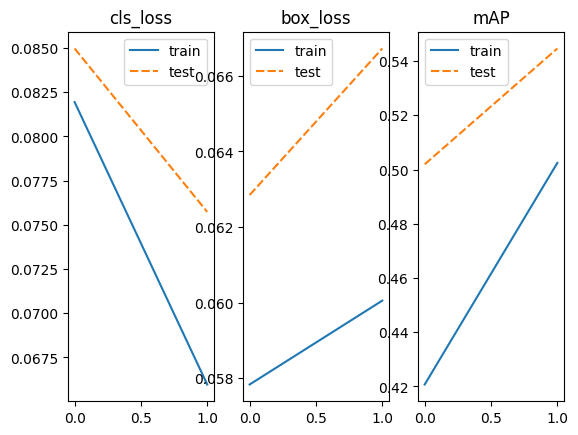

In [ ]:
metrics = np.array(metrics)
fig, ax = plt.subplots(1, 3)
sns.lineplot(data=pd.DataFrame(metrics[:, ::3], columns=['train', 'test']), ax=ax[0]).set(title='cls_loss')
sns.lineplot(data=pd.DataFrame(metrics[:, 1::3], columns=['train', 'test']), ax=ax[1]).set(title='box_loss')
sns.lineplot(data=pd.DataFrame(metrics[:, 2::3], columns=['train', 'test']), ax=ax[2]).set(title='mAP')
# sns.lineplot(data=metrics[:, ::6], ax=ax[0, 0]).set(title='train/cls_loss')
# sns.lineplot(data=metrics[:, 1::6], ax=ax[0, 1]).set(title='train/box_loss')
# sns.lineplot(data=metrics[:, 2::6], ax=ax[0, 2]).set(title='train/mAP')
# sns.lineplot(data=metrics[:, 3::6], ax=ax[1, 0]).set(title='test/cls_loss')
# sns.lineplot(data=metrics[:, 4::6], ax=ax[1, 1]).set(title='test/box_loss')
# sns.lineplot(data=metrics[:, 5::6], ax=ax[1, 2]).set(title='test/mAP')

В качестве второй модели будем использовать YOLO
Будем использовать последнюю (восьмую) версию этой нейросети, так как она разработана с учетом актуальных исследований в области ИИ

In [9]:
model = YOLO('yolov8n.pt')
model

100%|██████████| 6.23M/6.23M [00:00<00:00, 106MB/s]


Обучим модель

In [10]:
results = model.train(data='data.yaml', epochs=2, imgsz=640, device=device, plots=True)
results

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 25.6MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/train/labels... 8175 images, 69 backgrounds, 1 corrupt: 100%|██████████| 8175/8175 [00:04<00:00, 1828.35it/s]

train: WARNING ⚠️ /content/datasets/train/images/00000003-2-_jpg.rf.72b8917ccbb02feb768cfc5205d1232a.jpg: ignoring corrupt image/label: Label class 90 exceeds dataset class count 6. Possible class labels are 0-5


train: New cache created: /content/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/valid/labels... 780 images, 7 backgrounds, 1 corrupt: 100%|██████████| 780/780 [00:00<00:00, 801.46it/s]

val: WARNING ⚠️ /content/datasets/valid/images/gallery_used-car-carlist-toyota-hiace-van-malaysia_7200061_755081379_v1sm_jpg.rf.c09253dad7c35caee71a1366c0b0e11d.jpg: ignoring corrupt image/label: labels require 5 columns, 4 columns detected
val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      2.41G     0.8025      2.065      1.281         40        640: 100%|██████████| 511/511 [03:06<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]

                   all        779       1152      0.504      0.684      0.631      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      2.32G      0.723      1.322      1.208         49        640: 100%|██████████| 511/511 [03:00<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


                   all        779       1152      0.729      0.726      0.761      0.576

2 epochs completed in 0.108 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


                   all        779       1152      0.729      0.725       0.76      0.576
                  five        779        136      0.646      0.779      0.778      0.575
                  four        779        117      0.633      0.766      0.738      0.575
                   one        779        300      0.662      0.712      0.687       0.51
                   six        779        303      0.805      0.752      0.792      0.459
                 three        779        159      0.729      0.623      0.732      0.601
                   two        779        137      0.899      0.715      0.835      0.735
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ac52630c940>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Протестируем модель

In [11]:
results = model.val(device=device, plots=True)
results

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/valid/labels.cache... 780 images, 7 backgrounds, 1 corrupt: 100%|██████████| 780/780 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/valid/images/gallery_used-car-carlist-toyota-hiace-van-malaysia_7200061_755081379_v1sm_jpg.rf.c09253dad7c35caee71a1366c0b0e11d.jpg: ignoring corrupt image/label: labels require 5 columns, 4 columns detected



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


                   all        779       1152      0.728      0.724       0.76      0.576
                  five        779        136      0.646      0.779      0.778      0.576
                  four        779        117      0.633      0.768      0.737      0.576
                   one        779        300      0.662      0.712      0.688      0.511
                   six        779        303      0.797      0.749      0.793       0.46
                 three        779        159      0.729      0.623      0.732      0.601
                   two        779        137        0.9      0.715      0.835      0.735
Speed: 0.3ms preprocess, 4.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ac5324b7880>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

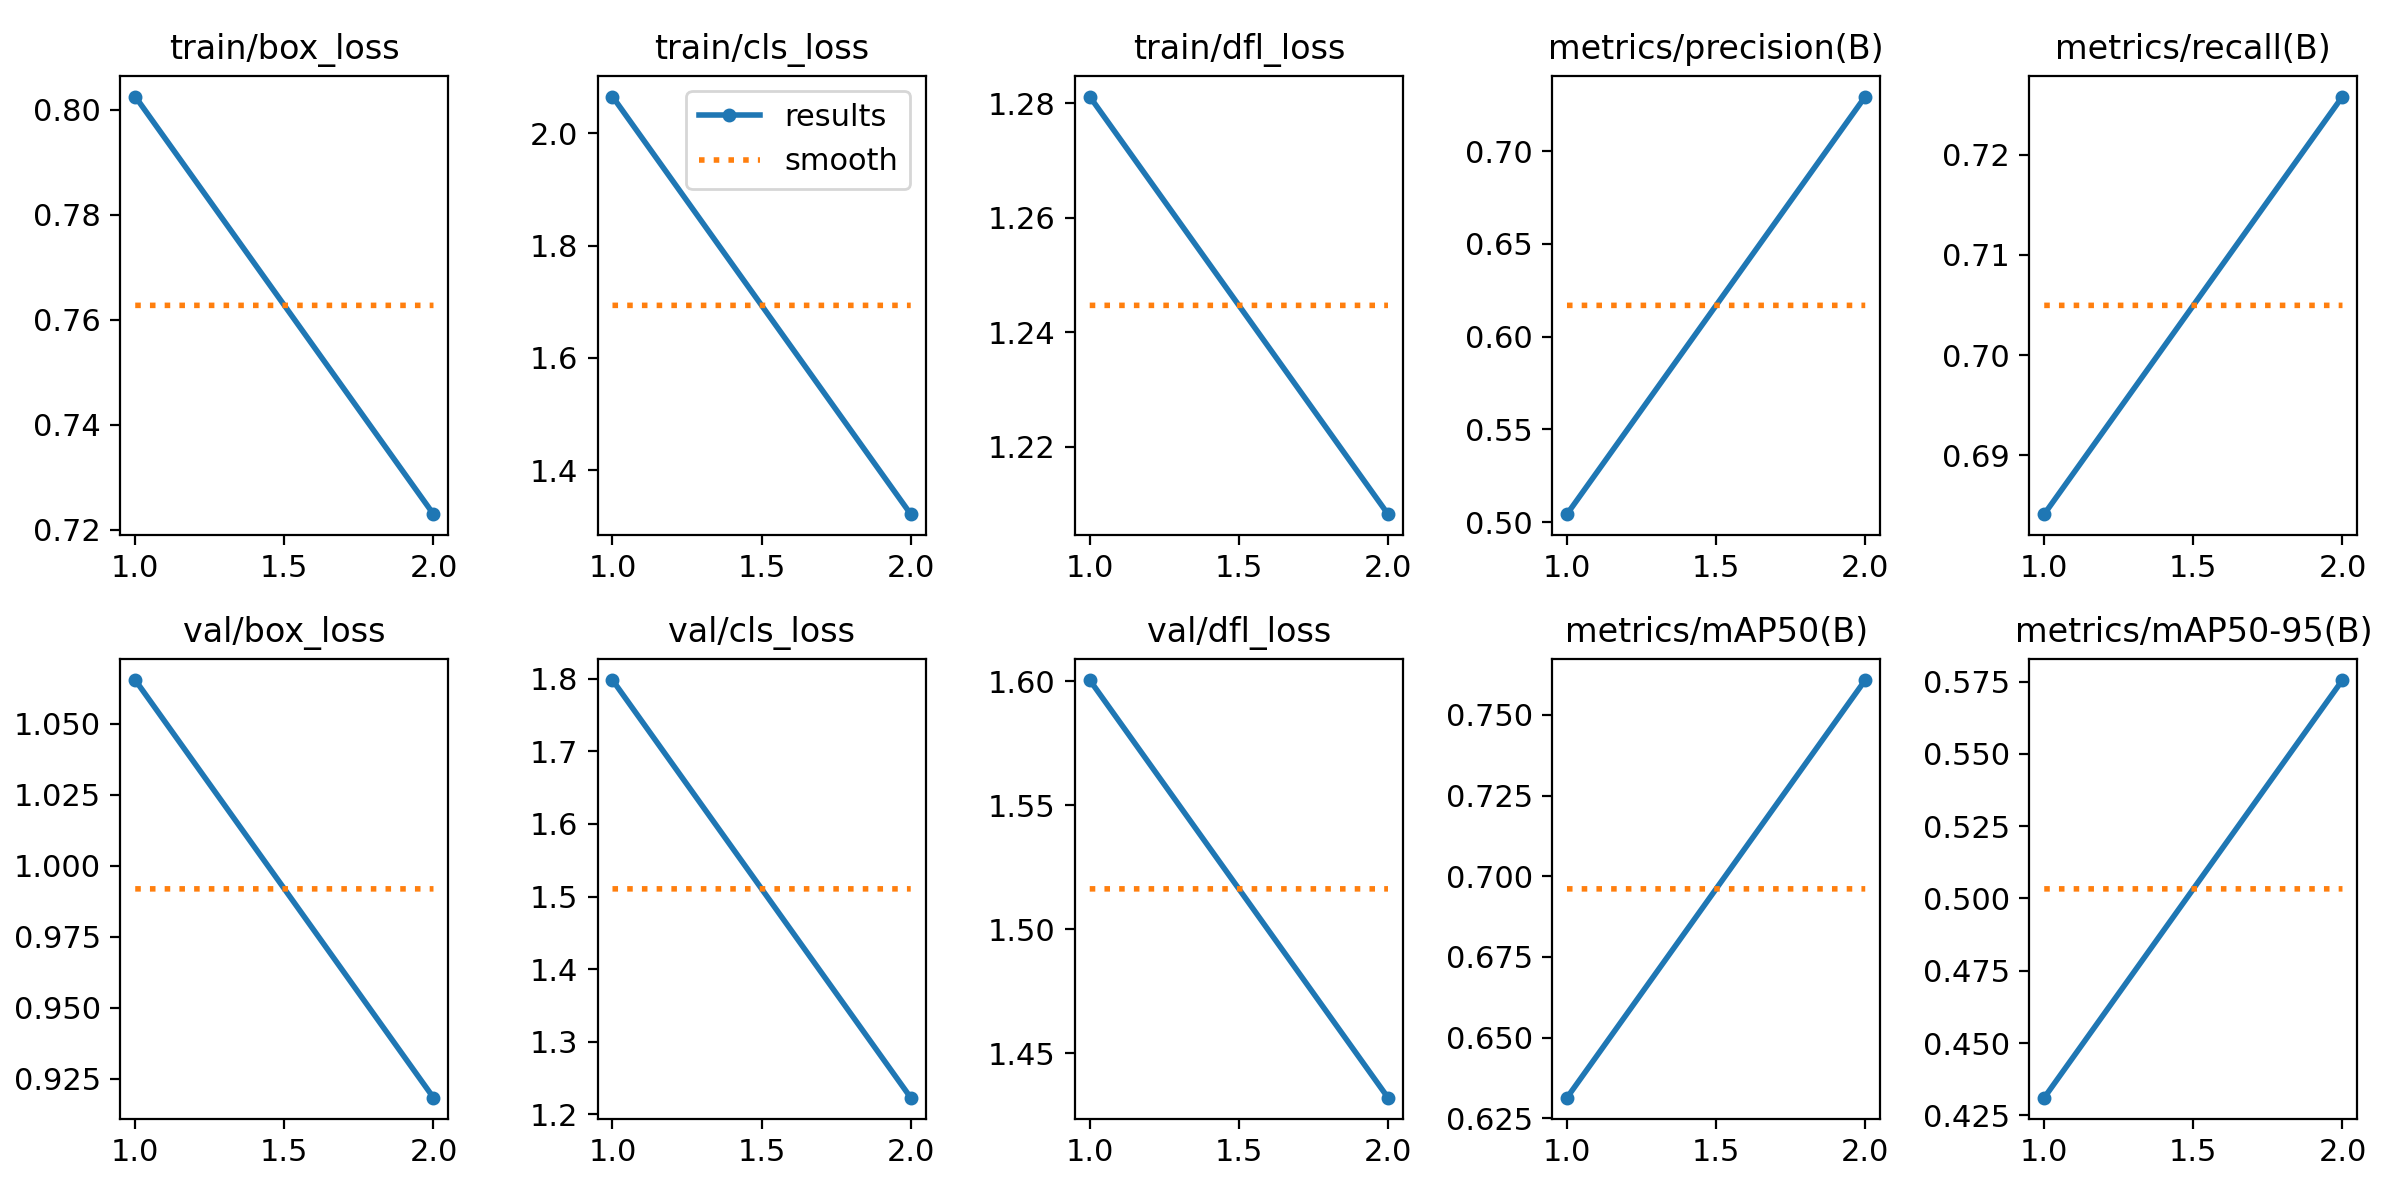

In [12]:
Image.open('runs/detect/train/results.png')

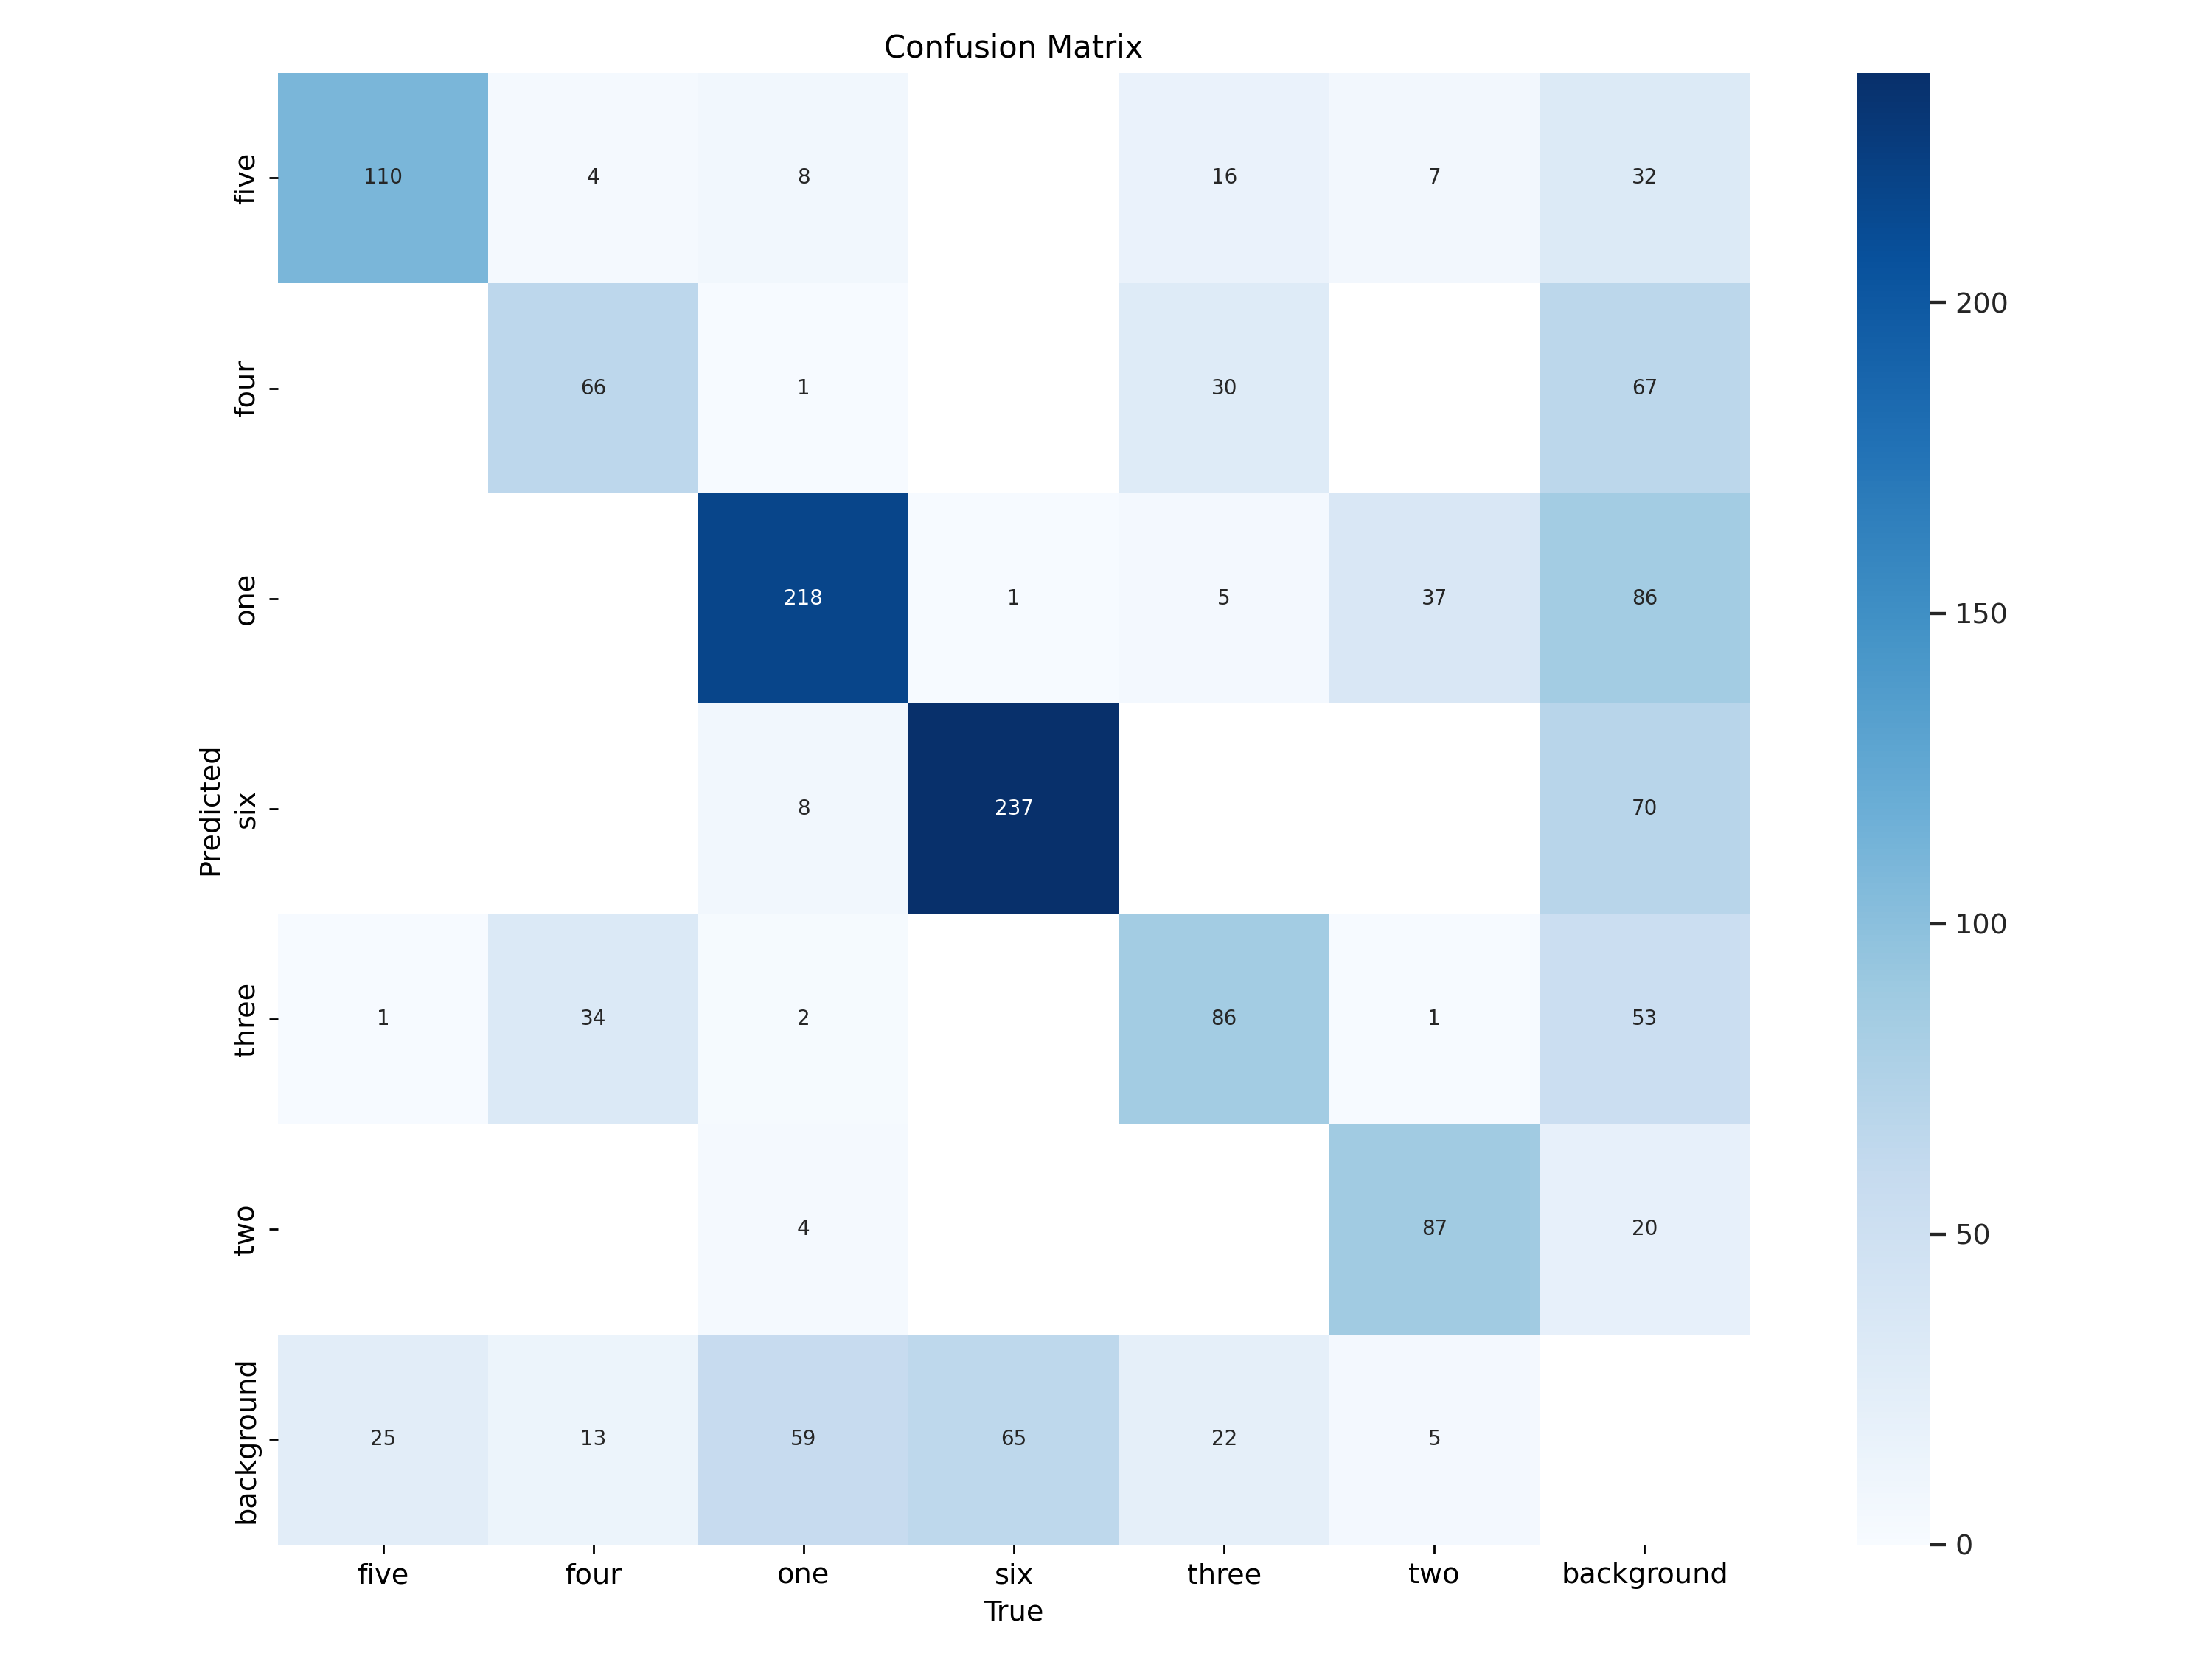

In [13]:
Image.open('runs/detect/train/confusion_matrix.png')

По графикам видно, что модель YOLO имеет loss и mAP лучше, и чем у R-CNN. Также YOLO работает быстрее, чем R-CNN, позволяя работать в режиме реального времени

В дальнейшем будем использовать YOLO. Лучшие веса сохранены по пути best.pt

Выполним предсказания на картинках директории test

In [12]:
model = YOLO('best.pt')
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [13]:
results = model.predict('datasets/test/images', imgsz=640, device=device, save=True, save_txt=True)
results

image 1/387 /Users/vre/DataspellProjects/mcrpo_2024/datasets/test/images/00000005_jpg.rf.c0592d40c2d47fde9e4ff688a3d320b7.jpg: 640x640 1 five, 1 three, 17.2ms
image 2/387 /Users/vre/DataspellProjects/mcrpo_2024/datasets/test/images/00000036-2-_jpg.rf.8c2a6dffb3cfe8fba3cabf080592fb19.jpg: 640x640 1 five, 1 four, 13.5ms
image 3/387 /Users/vre/DataspellProjects/mcrpo_2024/datasets/test/images/00000054_jpg.rf.9f080d5482e6a80d18c72898cc506344.jpg: 640x640 1 three, 17.5ms
image 4/387 /Users/vre/DataspellProjects/mcrpo_2024/datasets/test/images/00000072-2-_jpg.rf.7ea13ee6e82eb8f0d52135895ba48134.jpg: 640x640 1 four, 13.8ms
image 5/387 /Users/vre/DataspellProjects/mcrpo_2024/datasets/test/images/00000072_jpg.rf.7703ae4fbacf37a1eeb45fa182ccb665.jpg: 640x640 2 fours, 14.5ms
image 6/387 /Users/vre/DataspellProjects/mcrpo_2024/datasets/test/images/00000078_jpg.rf.5c783b94976f81ca75e372c51e56e745.jpg: 640x640 1 three, 12.7ms
image 7/387 /Users/vre/DataspellProjects/mcrpo_2024/datasets/test/images/0

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'five', 1: 'four', 2: 'one', 3: 'six', 4: 'three', 5: 'two'}
 obb: None
 orig_img: array([[[205, 195, 195],
         [203, 193, 193],
         [201, 191, 191],
         ...,
         [200, 195, 192],
         [202, 197, 194],
         [204, 199, 196]],
 
        [[201, 191, 191],
         [199, 189, 189],
         [197, 187, 187],
         ...,
         [196, 191, 188],
         [198, 193, 190],
         [200, 195, 192]],
 
        [[199, 189, 189],
         [197, 187, 187],
         [195, 185, 185],
         ...,
         [194, 189, 186],
         [196, 191, 188],
         [198, 193, 190]],
 
        ...,
 
        [[122, 118, 117],
         [121, 117, 116],
         [120, 116, 115],
         ...,
         [132, 169, 189],
         [132, 167, 187],
         [140, 176, 194]],
 
        [[124, 121, 117],
         [123, 120, 116],
       